# Reinforcement Learning Assignment - Text Flappy Bird #

$\textit{Chiara Roverato}$

## Understanding the environment

In [33]:
%load_ext autoreload
%autoreload 2

Importing libraries

In [34]:
import os, sys
import gymnasium as gym
import time
import text_flappy_bird_gym
import numpy as np
import agent
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from utils import *

Here, we choose to use the environmnent that returns the distance of the player from the pipe at each time step, as it will be easier to define states based on them than with the screen output environmnent.

In [61]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4) #TextFlappyBird-v0 or TextFlappyBird-screen-v0

obs = env.reset()

# iterate
while True:
    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)
    print(obs)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break

env.close()

(12, 2)
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[      @           | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=2)
(11, 1)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[      @             ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=1)
(10, 0)
Text Flappy Bird!
Score: 0
-------

The environment is defined as follows:
- $\texttt{env.action\_space}$ gives the number of actions. There are two actions: Idle (0) and Flap (1)
- $\texttt{env.metadata}$ gives the information about the render mode and the frame rate.
- $\texttt{env.observation\_space}$ returns a tuple with the $x\_range$, the $y\_range$ and the $y\_min$

In [45]:
print(env.observation_space) #x range, y range, y min
print(env.action_space) #idle (0) or flap (1)
print(env.metadata)

Tuple(Discrete(14), Discrete(22, start=-11))
Discrete(2)
{'render_modes': ['human'], 'render_fps': 4}


## Defining our design choices

We choose to implement to agents: one is a Q-learning agent and the other is an Expected Sarsa agent. Implementation of both can be found in the $\texttt{agent.py}$ file.

In [7]:
from agent import *
from utils import *
from tqdm import tqdm
from training import *

After designing our agents, we defined a training function so that the q-value function could learn over the episodes. The parameters used are:
- $epsilon$: The exploration-exploitation trade-off parameter. It determines the probability of taking a random action (exploration) versus choosing the action with the highest Q-value (exploitation).
- $eps\_decay$: The rate at which $\epsilon$ decays over time. It controls the balance between exploration and exploitation as the agent gains more experience.
- $eps\_min$: The minimum value of $\epsilon$.
- $step\_size$: The step size or learning rate parameter. It controls the size of updates to the Q-values during training. A smaller step size results in slower but more stable learning.
- $discount\_rate$: The discount factor. It determines the importance of future rewards relative to immediate rewards. A higher discount rate values long-term rewards more, encouraging the agent to prioritize actions that lead to higher cumulative rewards over time.
- $num\_episodes$: The number of episodes or training iterations.
- $num\_runs$:  The number of independent runs of the training procedure.

Implementation can be found in the $\texttt{training.py}$ file.

At first, we only considered the y component of the observation. However, this yielded to bad results so we added a state dictionnary to map each couple (x,y) to a unique identifier.

After implementing this dictionary, we still had poor performance. No matter the choice of parameters, the agent failed at a score of $0$ or $1$ and the reward was of only $100$ on average after $10.000$ steps. In the following plot, you can observe the reward of a Q-learning agent across $10.000$ episodes. The training time was of $40$ seconds.

![Image Description](img/rwd_wo_epsdecay.png)


Then, taking into account a bit more the context of the game, where each choice can be critical, we decided to implement a epsilon decay. We obtained these performances with the Q-learning agent (the training time went from 40 seconds to 5 hours):

In [ ]:
all_run_rewards, all_run_scores, time, agent = train(epsilon=0.5, step_size=0.2, discount=0.95,num_episodes=10000)
plot_results(all_run_rewards, all_run_scores,epsilon=0.5, step_size=0.2, discount=0.95)

![Image Description](img/rwd_w_epsdecay.png)

We notice that after $10.000$ episodes, the agent could reach scores of up to $100.000$ and $10.000$ on average. It reaches convergence after $9.000$ episodes. However, since an episode ends when the bird touches a pipe or the ground, the better the agent, the longer the episode is and the training time increased exponentially. Thus, we added a condition: the episodes ends if the agent fails or if the score is superior to a predifined value.

Here, we retrained the same agent (Q-learning) but with the $1.000$ maximum score imposed. We decreased the training time from five hours to one.

In [30]:
all_run_rewards, all_run_scores, time, agent = train(epsilon=0.5, step_size=0.2, discount=0.95,num_episodes=10000)

100%|██████████| 10000/10000 [57:29<00:00,  2.90it/s] 


<Figure size 1400x500 with 0 Axes>

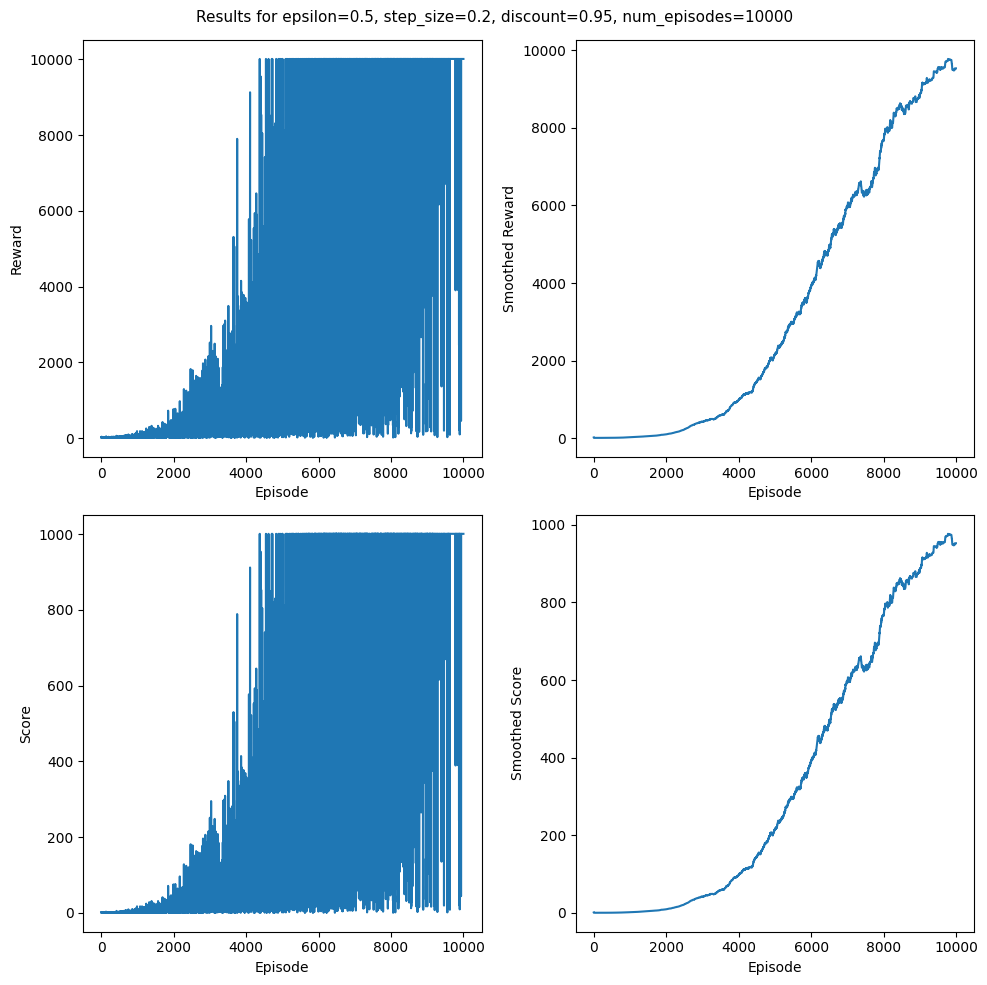

In [41]:
plot_results(all_run_rewards, all_run_scores,epsilon=0.5, step_size=0.2, discount=0.95,num_episodes=10000)

## Expected Sarsa: Finetuning the parameters

Because of the long training time, we will check for the optimal parameters by imposing a maximum score of 2000 and train on 8000 episodes (corresponds to the first inflexion point).

In [ ]:
epsilon_range = [0.1, 0.3, 0.5]
step_size_range = [0.1, 0.3, 0.5]
discount_range = [0.9,1]

results = {}

for epsilon in epsilon_range:
    for step_size in step_size_range:
        for discount in discount_range:
            print(f"Training for epsilon={epsilon}, step_size={step_size}, discount={discount}")
            all_run_rewards, all_run_scores,time = train(epsilon, step_size, discount, num_episodes=8000 ,num_runs=1,eps_decay=0.999,eps_min=1e-5,algorithm='ExpectedSarsa')
            results[(epsilon, step_size, discount)] = (all_run_rewards, all_run_scores,time)


Due to the long running time, the above cell was computed on a parallel notebook to save time. The results are uploaded in the next cell.

In [2]:
filepath = 'results_sarsa.pkl'

with open(filepath, 'rb') as f:
    results_sarsa = pickle.load(f)

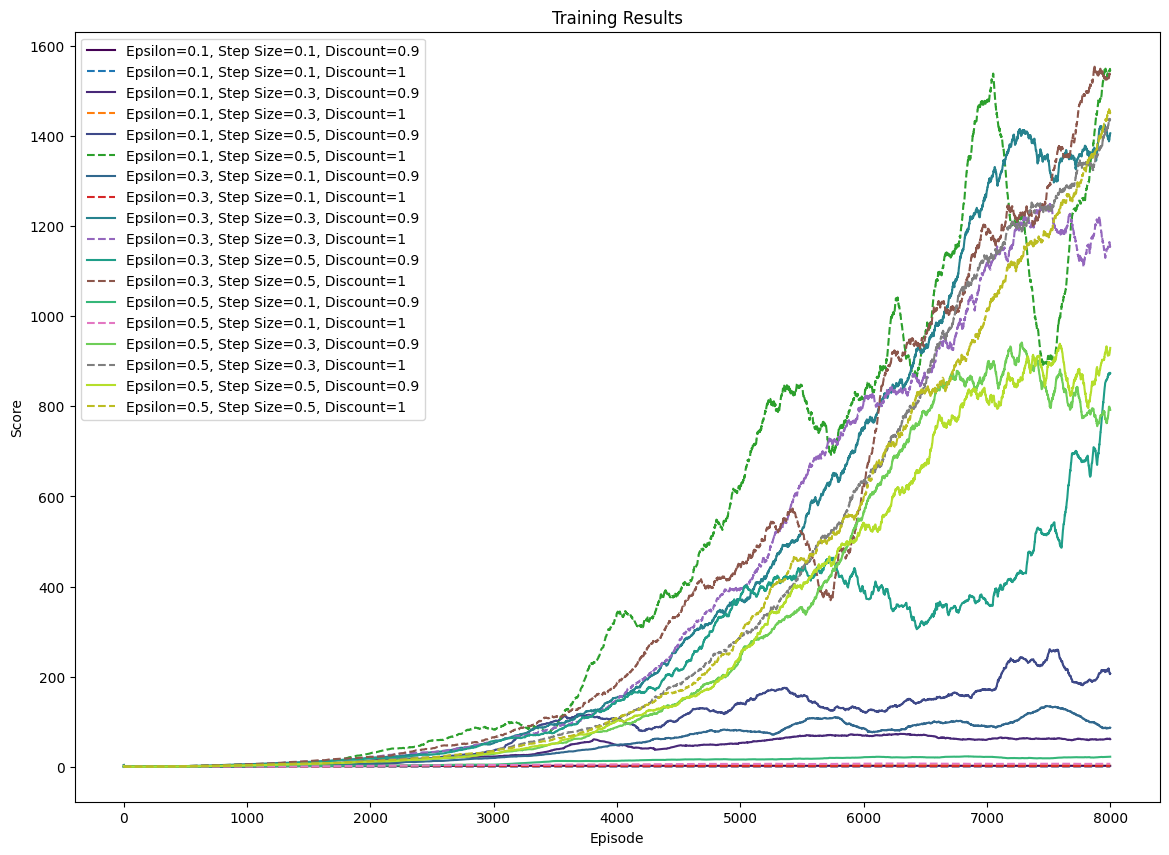

In [14]:
plot_results_para(results_sarsa)

We notice in this plot that the best results are obtained for a discount rate of $1$. Furthermore, a step size of $0.5$ almost always yields to better results. The best results are obtained for $\epsilon=0.1$ or $\epsilon=0.3$. The first reaches its maximum before and performs better than the second thoughout the training but is more invariant.\
We will still keep this set of values : $\epsilon=0.1$, $discount\_rate=1$, $step\_size=0.5$

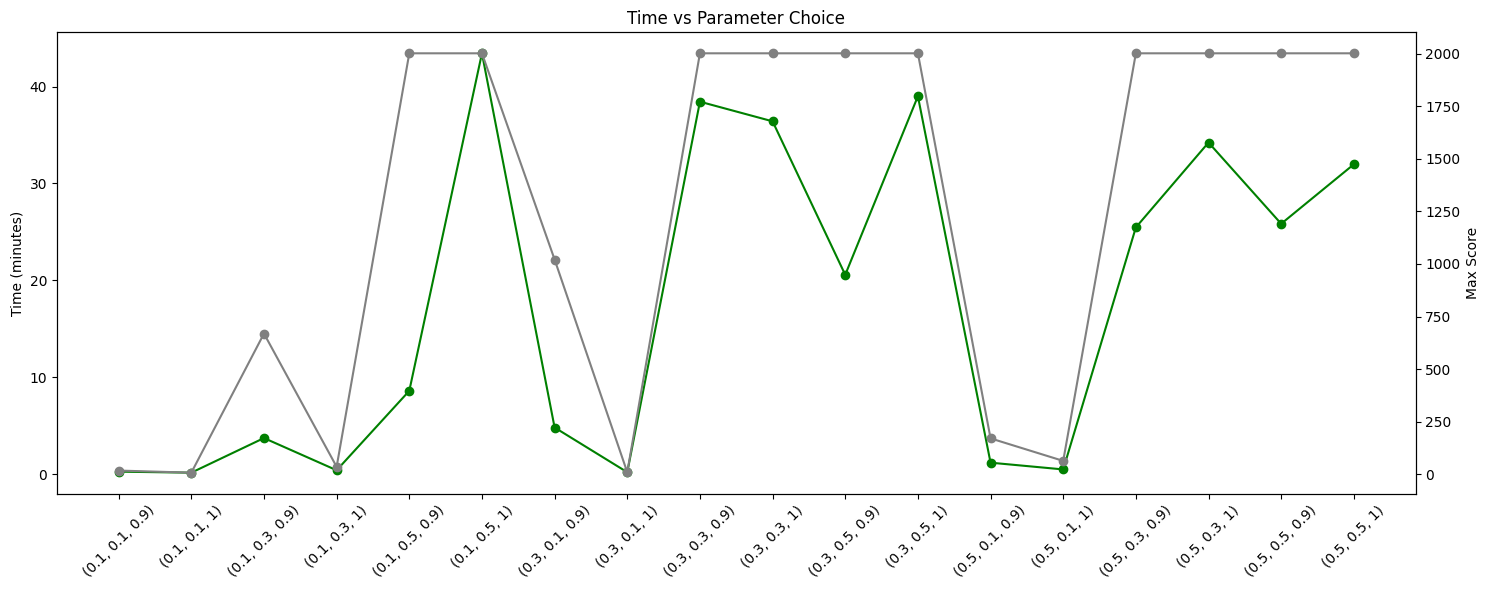

In [13]:
plot_time(results_sarsa)

As expected, we notice that the running time is very correlated to the performance of the agent.

## Q-learning: Finetuning the parameters

In [ ]:
epsilon_range = [0.1, 0.3, 0.5]
step_size_range = [0.1, 0.3, 0.5]
discount_range = [0.9,1]

results_bis = {}

for epsilon in epsilon_range:
    for step_size in step_size_range:
        for discount in discount_range:
            print(f"Training for epsilon={epsilon}, step_size={step_size}, discount={discount}")
            all_run_rewards, all_run_scores,time = train(epsilon, step_size, discount, num_episodes=8000 ,num_runs=1,eps_decay=0.999,eps_min=1e-5,algorithm='Q-learning')
            results_bis[(epsilon, step_size, discount)] = (all_run_rewards, all_run_scores,time)


In [24]:
import pickle
filepath = 'results_qlearning.pkl'

with open(filepath, 'rb') as f:
    results_q= pickle.load(f)

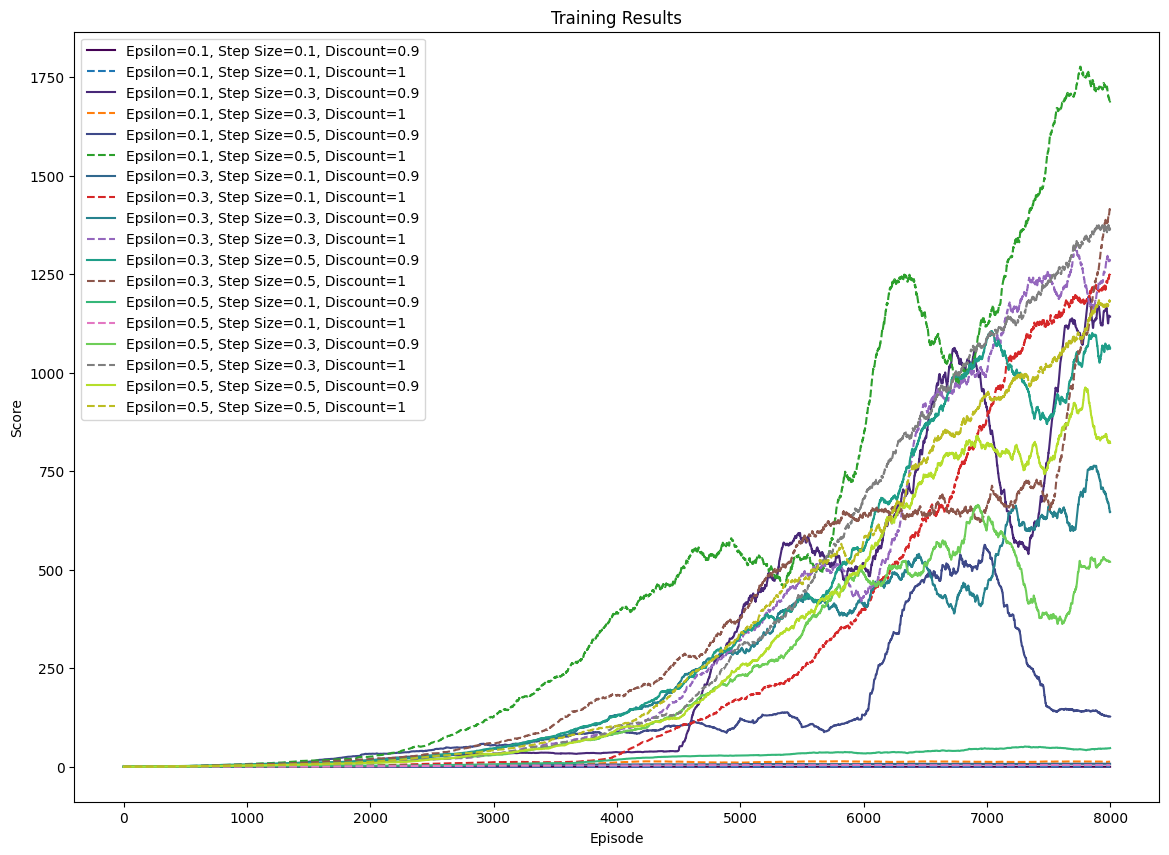

In [25]:
plot_results_para(results_q)

The best results are obtained for $\epsilon=0.1$, $discount\_rate=1$, $step\_size=0.5$.

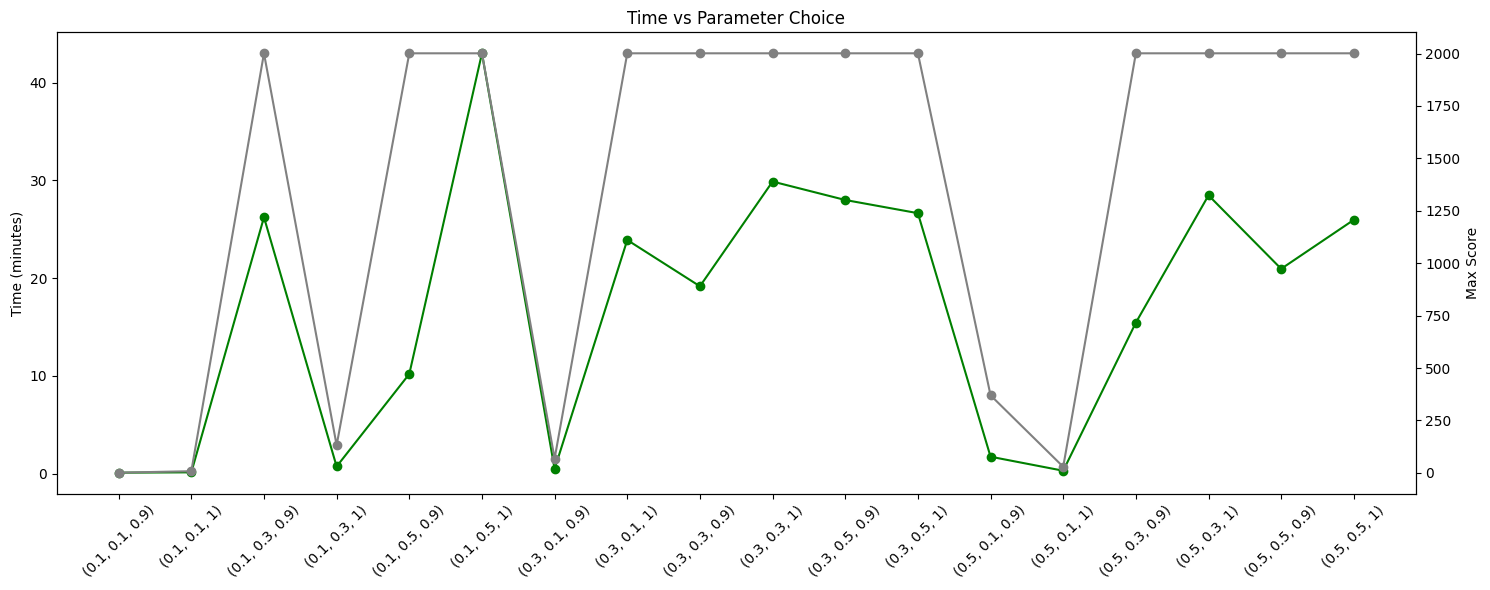

In [26]:
plot_time(results_q)

## Models comparison

In [21]:
reward_sarsa, score_sarsa, time_sarsa, agent_sarsa = train(epsilon=0.1, step_size=0.5, discount=1,num_episodes=7000,algorithm='ExpectedSarsa')

100%|██████████| 7000/7000 [35:59<00:00,  3.24it/s]  


<Figure size 1400x500 with 0 Axes>

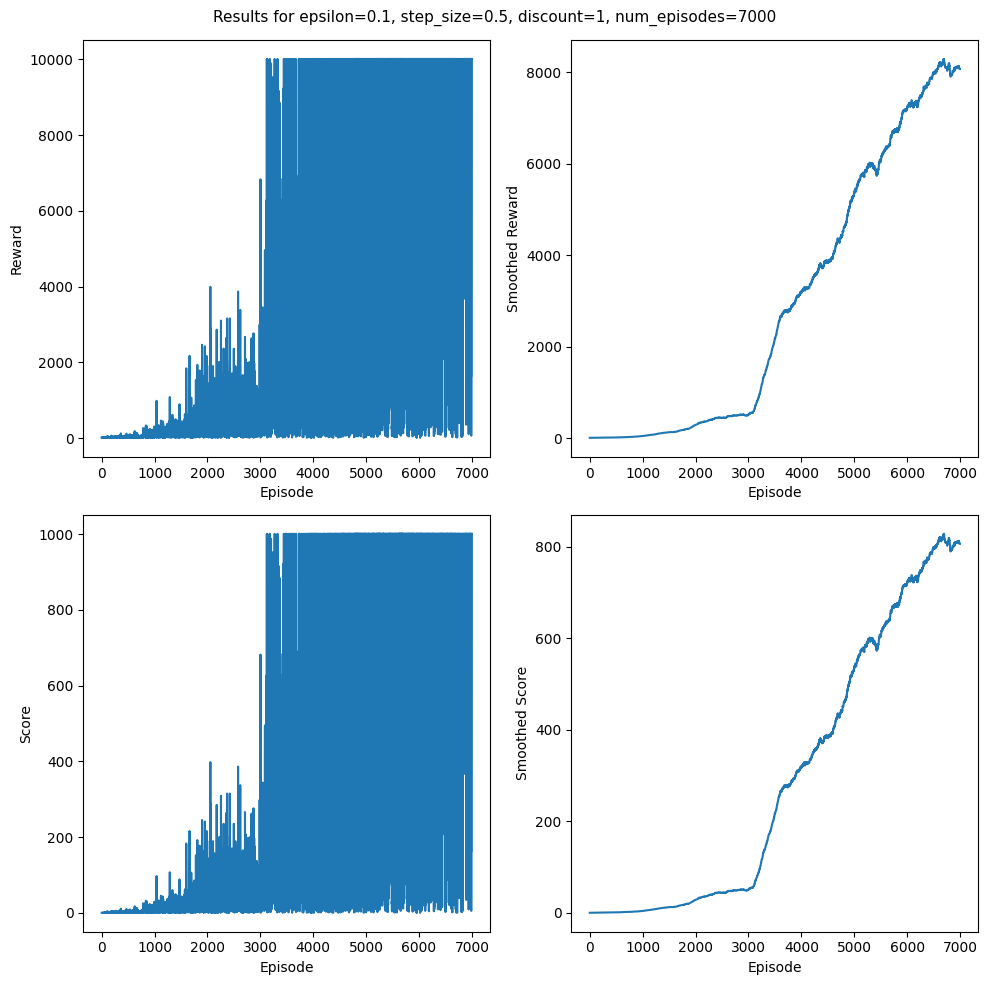

In [51]:
plot_results(reward_sarsa, score_sarsa,epsilon=0.1, step_size=0.5, discount=1,num_episodes=7000)

In [27]:
reward_q, score_q, time_q, agent_q = train(epsilon=0.1, step_size=0.5, discount=1,num_episodes=7000,algorithm='Q-learning')

100%|██████████| 7000/7000 [24:28<00:00,  4.77it/s]  


<Figure size 1400x500 with 0 Axes>

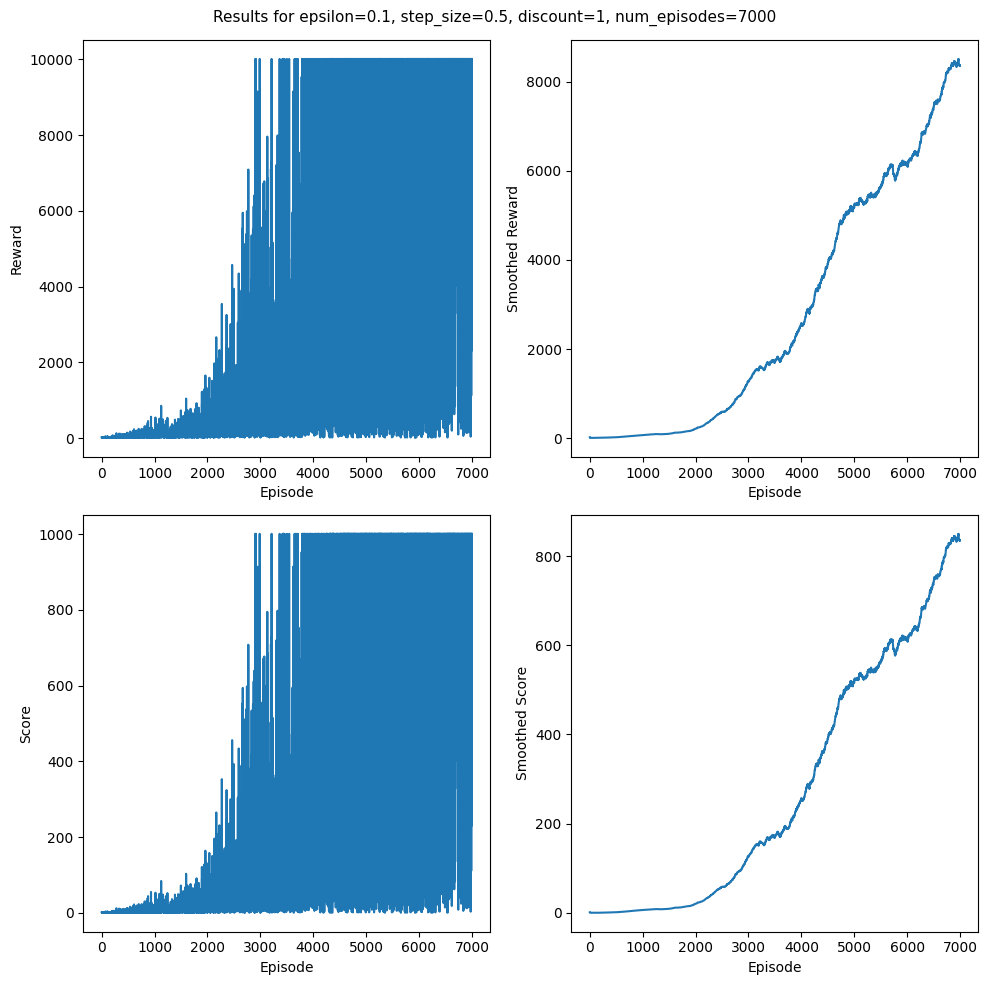

In [52]:
plot_results(reward_q, score_q,epsilon=0.1, step_size=0.5, discount=1,num_episodes=7000)

In [37]:
def plot_comparison(R1, R2,name1,name2):
    plt.figure(figsize=(14,5))
    sR1 = pd.Series(R1).rolling(500, min_periods=1).mean()
    sR2 = pd.Series(R2).rolling(500, min_periods=1).mean()
    plt.plot(sR1,label=name1)
    plt.plot(sR2,label=name2)
    plt.legend()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Comparison between {name1} and {name2}',fontsize=11)
    plt.show()

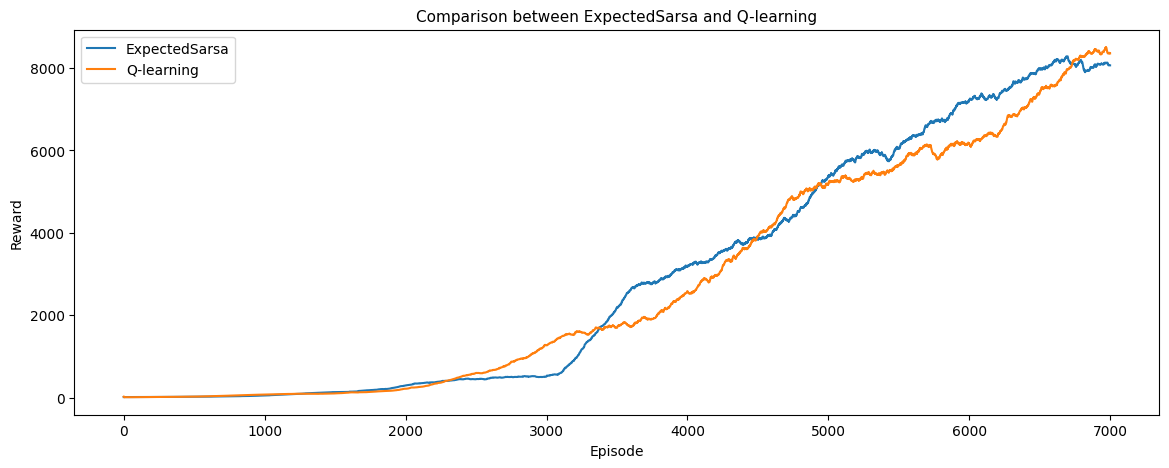

In [38]:
plot_comparison(reward_sarsa, reward_q,'ExpectedSarsa','Q-learning')

We then plotted the state-value function or our model: we notice that the states for which the expected reward is the highest correspond to the states around an ordinate $y$ value of 0. The closer the abscissa $x$ gets to the pipes, the narrower the state-value function gets. It is consistent with our problem, since the closer we get to the pipes, the more dangerous the situation is.

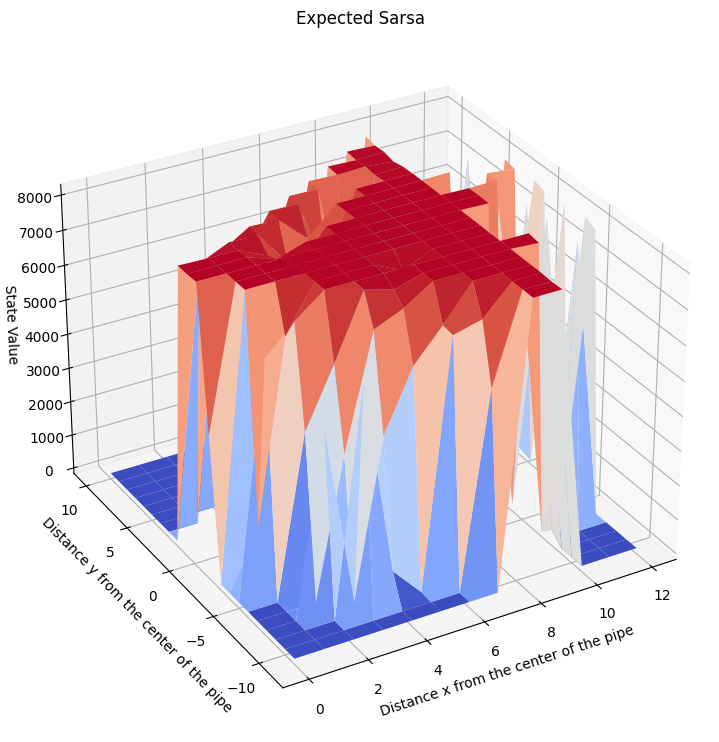

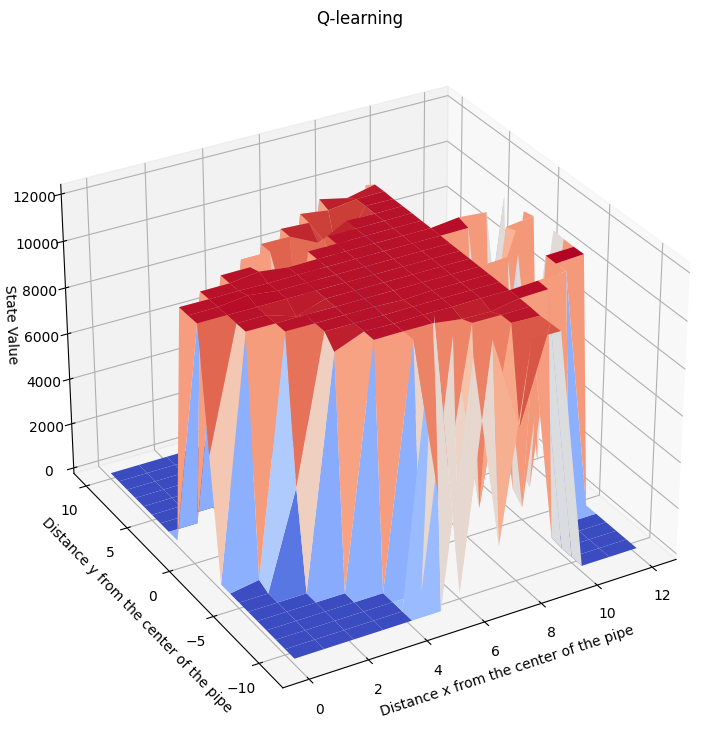

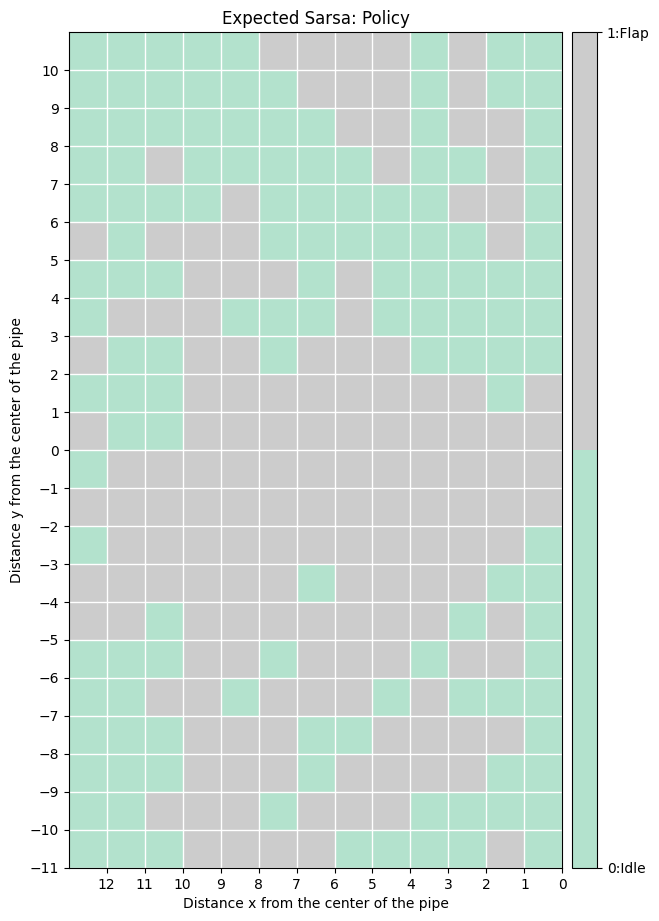

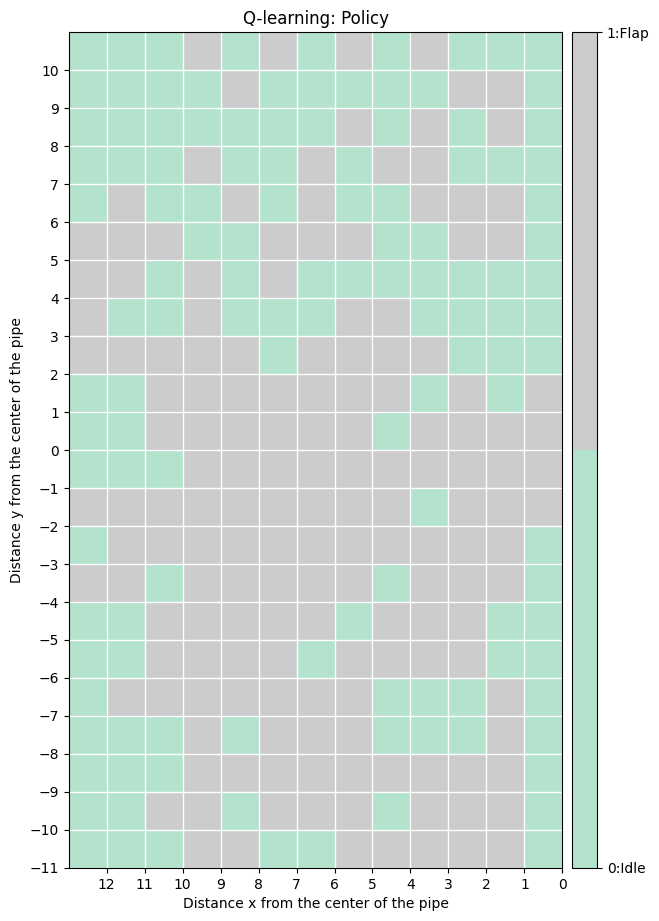

In [41]:
plot_SV(agent_sarsa,height=15,width=20,pipe_gap=4,title='Expected Sarsa')
plot_SV(agent_q,height=15,width=20,pipe_gap=4,title='Q-learning')
plot_policy(agent_sarsa,height=15,width=20,pipe_gap=4,title='Expected Sarsa')
plot_policy(agent_q,height=15,width=20,pipe_gap=4,title='Q-learning')

## Testing the agents on different level configurations

In [43]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4) #TextFlappyBird-v0 or TextFlappyBird-screen-v0
# obs = env.reset()
# state=obs[0]
agent = agent_sarsa

num_episodes=100
scores=[]
# iterate
for i in range(num_episodes):
    obs = env.reset()
    state=obs[0]
    reward=0
    action = agent.agent_start(state)

    while True:
        action = agent.agent_step(reward, state)
        obs, reward, done, _, info = env.step(action)
        state=obs

        # # Render the game
        # os.system("clear")
        # sys.stdout.write(env.render())
        # time.sleep(0.2) # FPS
        
        if done:
            agent.agent_end(reward)
            scores.append(info['score'])
            break
    env.close()

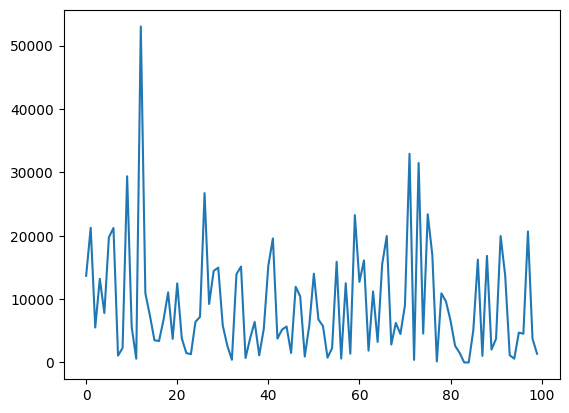

In [44]:
plt.plot(scores)

  1%|          | 1/100 [00:00<00:33,  2.95it/s]

100%|██████████| 100/100 [00:08<00:00, 12.04it/s]


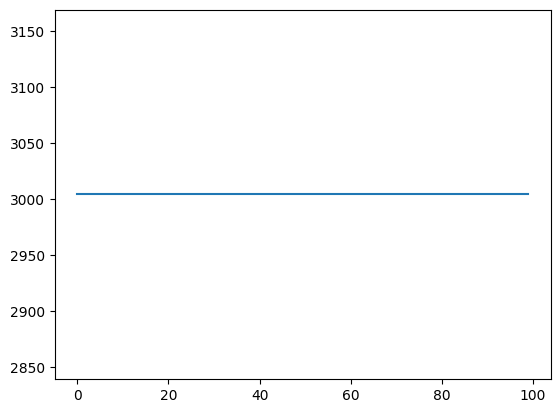

In [88]:
agent = agent_sarsa

def get_Z(x, y,agent):
    if (x,y) in agent.state_index.keys():
        return np.argmax(agent.q[agent.state_index[(x,y)]])
    else:
        return -1 
    
def train(agent,num_episodes):
        rewards = []
        env = gym.make('TextFlappyBird-v0', height = 10, width = 5, pipe_gap = 6) #TextFlappyBird-v0 or TextFlappyBird-screen-v0
        for i in tqdm(range(num_episodes)):
            obs = env.reset()
            obs = obs[0]
            reward = 0
            while True:
                obs, r, done, _, info = env.step(get_Z(obs[0],obs[1],agent))
                reward += r
                if done or info['score'] > 1000:
                    break
            rewards.append(reward)
            env.close()
        return rewards
rewards=train(agent,100)
plt.plot(rewards)